### Import Module

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision import utils
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
%matplotlib inline
from torchsummary import summary
from tqdm import tqdm
import os
import collections
import numpy as np
import copy
import time

/Users/leebyeonghwa/.local/share/virtualenvs/paper-ttdSXBrN/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


#### Device Check

In [2]:
device = torch.device(torch.device("mps:0") if torch.backends.mps.is_available() else 'cpu')

print(device)
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.

device='cpu'
!python -c 'import platform;print(platform.platform())'

mps:0
PyTorch version:2.0.1
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-13.5-arm64-arm-64bit


### Define hyper parameter

In [3]:
# define hyper parameter

image_size = 227
epoch = 10
lr = 0.001

### Load Data

In [4]:
# data load

data_path = './data'

if not os.path.exists(data_path):
    print(os.getcwd())
    # os.mkdir(data_path)

data_transformer = transforms.Compose([transforms.ToTensor()])
train_data = datasets.STL10(root=data_path, download=True, split='train', transform=data_transformer)
test_data = datasets.STL10(root=data_path, download=True, split='test', transform=data_transformer)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_data.data.shape

(5000, 3, 96, 96)

In [6]:
def show(img, y=None, color=True):

    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)
    
    # plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(y))


3287
images indices:  3287


/var/folders/h9/qp3tmth537bgnryg58zf2p_40000gn/T/ipykernel_26642/3235672916.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rnd_var = int(np.random.randint(0, len(train_data), 1))


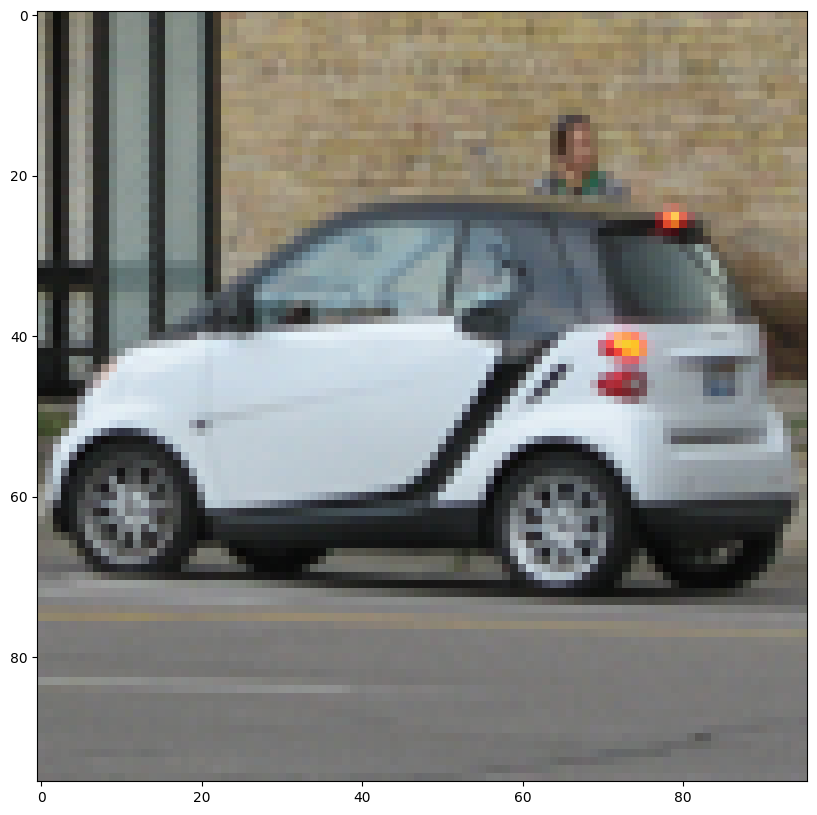

In [7]:
rnd_var = int(np.random.randint(0, len(train_data), 1))
print(rnd_var)
img, label = train_data[rnd_var]
print('images indices: ', rnd_var)

plt.figure(figsize=(10, 10))
show(img)

In [8]:
y_train = [y for _, y in train_data]
counter_train = collections.Counter(y_train)
print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


### Calculate Mean and Std

In [9]:
train_mean = train_data.data.mean(axis=(0, 2, 3))/255
train_std = train_data.data.std(axis=(0, 2, 3))/255
test_mean = test_data.data.mean(axis=(0, 2, 3))/255
test_std = test_data.data.std(axis=(0, 2, 3))/255

print(train_mean)
print(train_std)
print(test_mean)
print(test_std)

[0.44671062 0.43980984 0.40664645]
[0.26034098 0.25657727 0.27126738]
[0.44723063 0.43964247 0.40495725]
[0.2605645  0.25666146 0.26997382]


### Set Transformper

In [10]:
# transform

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(size=(image_size, image_size)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std)
])

In [11]:
# set transformation

train_data.transform = train_transform
test_data.transform = test_transform

In [12]:
images, labels = next(iter(train_data))


In [13]:
images.shape

torch.Size([3, 227, 227])

In [14]:
test_data.data.shape

(8000, 3, 96, 96)

In [15]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = list(range(len(test_data)))
y_test = [y for y in test_data.labels]

for test_index, val_index in sss.split(indices, y_test):
    print('test :', len(test_index) , 'val :', len(val_index))

val_data = Subset(test_data, val_index)
splited_test_data = Subset(test_data, test_index)

test : 6400 val : 1600


In [16]:
test = [y for _, y in splited_test_data]
val = [y for _, y in val_data]
counter_test = collections.Counter(test)
counter_val = collections.Counter(val)
print(counter_test)
print(counter_val)

Counter({6: 640, 0: 640, 4: 640, 5: 640, 9: 640, 2: 640, 3: 640, 1: 640, 7: 640, 8: 640})
Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})


#### Data Loader

In [17]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(splited_test_data, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)

#### AlexNet architecure
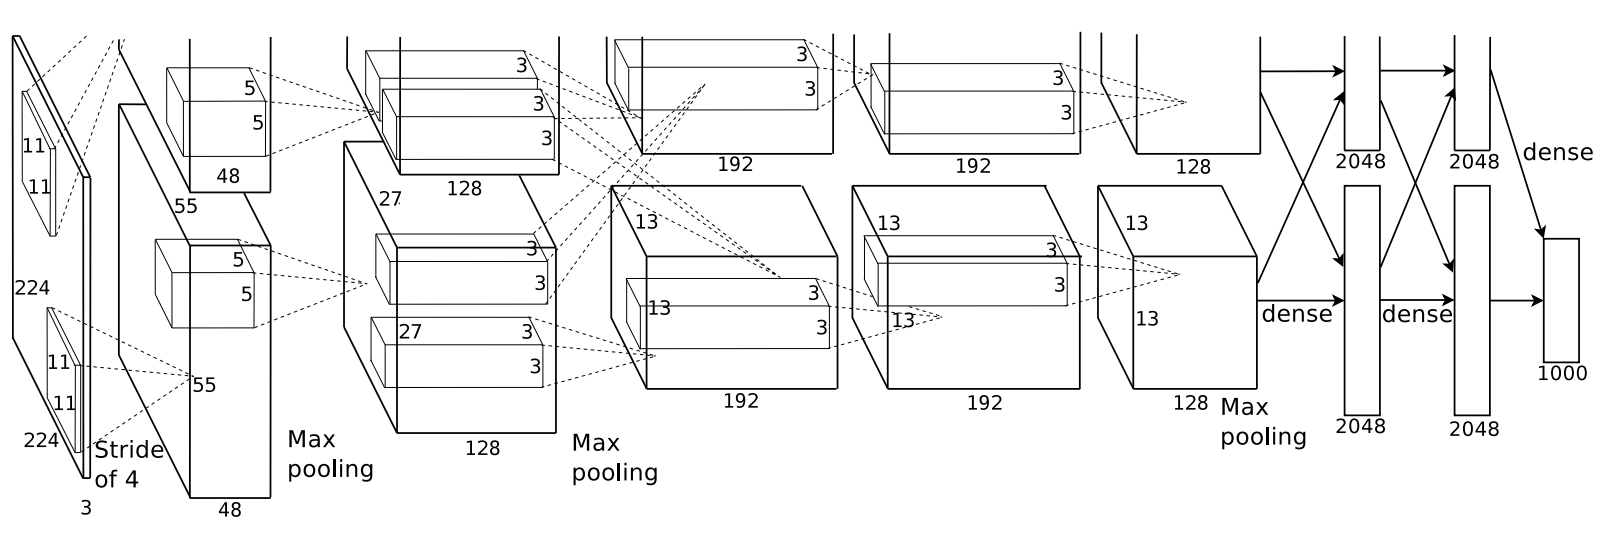
224 -> 227
또 논문에서는 GPU 2로 나누어서 학습을 하였기때문에 채널의 크기를 2배로함.

### Define AlexNet

In [18]:
class AlexNet(nn.Module):
    def __init__(self, in_channel=3, num_class=10, init_weight = True):
        super(AlexNet, self).__init__()
        self.in_channel = in_channel
        self.num_class = num_class
        self.init_weight = init_weight
        self._define_layers()

    # featuremap size = (size-kernel_size+2*padding)/stride + 1
    def _define_layers(self):
        self.layer = nn.Sequential(
            # layer 1
            # input =  (b, 3, 227, 227)
            nn.Conv2d(in_channels=self.in_channel, out_channels=96, kernel_size=(11, 11), stride=4, padding=0),
            nn.ReLU(),
            # input = (96, 55, 55)
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # layer 2
            # input = (96, 27, 27)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), stride=1, padding=2),
            # input = (256, 27, 27)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),


            # layer 3
            # input = (256, 13, 13)
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),

            # layer 4
            # input = (384, 13, 13)
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),

            # layer 5
            # input = (384, 13, 13)
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            # input = (256, 6, 6)
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256*6*6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=self.num_class),
        )

    def _init_weights(self):
        """
        initalize weights
        """
        if self.init_weight:
            for layer in self.modules:
                if isinstance(layer, nn.Conv2d):
                    nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
                elif isinstance(layer, nn.BatchNorm2d):
                    nn.init.constant_(layer.weight, 1)
                    nn.init.constant_(layer.bias, 0)

                elif isinstance(layer, nn.Linaer):
                    nn.init.normal_(layer.weight, 0, 0.01)
                    nn.init.constant_(layer.bias, 0)

            # in paper, initialize bias to 1 for conv2, 4, 5 layer
            nn.init.constant_(self.modules[4].bias, 1)
            nn.init.constant_(self.modules[10].bias, 1)
            nn.init.constant_(self.modules[12].bias, 1)



    def forward(self, x):

        x = self.layer(x)
        x = x.view(-1, 256*6*6)
        x = self.classifier(x)

        return x


In [19]:
model = AlexNet()
model.to(device)
print(model)

AlexNet(
  (layer): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): 

In [20]:
summary(model, input_size=(3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [21]:
# check weight initialization
for p in model.parameters():
    print(p)
    break

Parameter containing:
tensor([[[[ 5.0279e-02,  1.1927e-02, -2.3004e-02,  ...,  4.9277e-02,
            4.3433e-02,  5.2049e-02],
          [ 9.8804e-03,  5.0779e-02, -1.8651e-02,  ...,  9.1067e-03,
           -4.3392e-02,  1.5135e-02],
          [ 3.7000e-02,  4.1061e-02, -3.2274e-02,  ...,  2.9781e-02,
            1.0132e-02, -4.5810e-02],
          ...,
          [ 3.0223e-02,  4.9964e-02, -4.9349e-02,  ..., -4.1060e-02,
            3.9098e-02, -1.8106e-02],
          [-3.3454e-03, -3.1890e-02,  5.0468e-02,  ...,  3.1801e-02,
           -3.8763e-02,  2.8285e-02],
          [ 2.8617e-02,  8.9437e-03,  1.3364e-02,  ...,  2.9620e-03,
            4.6204e-02, -2.8207e-02]],

         [[-1.6877e-02,  5.4295e-03,  1.8616e-02,  ..., -4.9406e-02,
           -3.2283e-02,  1.5131e-02],
          [ 2.8713e-02, -1.6087e-02, -2.3107e-02,  ...,  4.8384e-02,
            2.2836e-02, -4.6880e-02],
          [ 8.7075e-03, -1.0227e-02, -5.2500e-04,  ...,  3.1559e-02,
            3.7109e-02,  4.7293e-02]

#### Train model

In [22]:
def train(model, data_loader, val_data_loader, epoch, device):
    # model.train()
    loss_function = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # define lr_scheduler : 1/10 per 10 epochs
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    def get_lr(optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']
        
    # define a function to count the number of correct predictions per mini-batch
    def metrics_batch(output, target):
    # get output class
        pred = output.argmax(dim=1, keepdim=True)
        # compare output class with target class
        corrects = pred.eq(target.view_as(pred)).sum().item()
        return corrects
    
    # define a function to compute the loss value per mini-batch
    def loss_batch(loss_function, output, target, optimizer=None):
        loss = loss_function(output, target)

        metric_b = metrics_batch(output, target)
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        return loss.item(), metric_b
    
    # develop a function to compute the loss value and the performance metric for the epoch
    def loss_epoch(model, loss_function, data_loader, sanity_check=False, optimizer=None):
        running_loss = 0
        running_metric = 0
        len_data = len(data_loader.dataset)
        progress = tqdm(data_loader)

        for batch_idx, (img, label) in enumerate(progress):
            # move batcch to device
            img = img.to(device)
            label = label.to(device)
            # get model output
            output = model(img)

            # get loss per batch
            loss_b, metric_b = loss_batch(loss_function, output, label, optimizer)

            # update running loss
            running_loss += loss_b
            # update running metric
            if metric_b is not None:
                running_metric += metric_b
            
            # break the loop in case of sanity check
            if sanity_check is True:
                break

        # average loss value and metric value
        loss = running_loss / float(len_data)
        metric = running_metric / float(len_data)
        return loss, metric
    

    
    # keep a history of the loss and the metric value
    loss_history = {
        'train': [],
        'val': [],
    }

    metric_history = {
        'train': [],
        'val': [],
    }


    # save the best perfirming model
    best_model_wts = copy.deepcopy(model.state_dict())

    # initializer the best loss to an infinite value
    best_loss = float('inf')

    for epoch_num in range(epoch):
        start_time = time.time()

        # get current learning rate
        current_lr = get_lr(optimizer=optimizer)
        print('Epoch {}/{}, current lr={}'.format(epoch_num, epoch-1, current_lr))

        model.train()

        # train model 1 epoch
        train_loss, train_metric = loss_epoch(model=model, loss_function=loss_function, data_loader=data_loader, optimizer=optimizer)

        # collect loss and metric for the training dataset
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_function=loss_function, data_loader=val_data_loader)
        
        # store the best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            # store weights into a local file
            torch.save(model.state_dict(), './model/weigths.pt')
            print('Copied best model weights')

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # update the learning rate
        lr_scheduler.step()
        if current_lr != get_lr(optimizer=optimizer):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        # print the loss and accuracy values and return the trained model
        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f, time: %.4f s' %(train_loss, val_loss, 100*val_metric, time.time()-start_time))
        print('-'*10)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history


In [23]:
model, loss_history, metric_history = train(model=model, data_loader=train_dataloader, val_data_loader=val_dataloader, epoch=epoch, device=device)

Epoch 0/9, current lr=0.001


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


Copied best model weights
train loss: 2.298846, dev loss: 2.207883, accuracy: 16.88, time: 160.9624 s
----------
Epoch 1/9, current lr=0.001


100%|██████████| 50/50 [00:20<00:00,  2.49it/s]


Copied best model weights
train loss: 2.026230, dev loss: 1.823901, accuracy: 26.50, time: 161.5399 s
----------
Epoch 2/9, current lr=0.001


100%|██████████| 50/50 [00:20<00:00,  2.38it/s]


Copied best model weights
train loss: 1.803941, dev loss: 1.699801, accuracy: 32.94, time: 164.7114 s
----------
Epoch 3/9, current lr=0.001


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


Copied best model weights
train loss: 1.688603, dev loss: 1.576541, accuracy: 39.62, time: 174.7590 s
----------
Epoch 4/9, current lr=0.001


100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


Copied best model weights
train loss: 1.592938, dev loss: 1.518189, accuracy: 40.06, time: 174.8332 s
----------
Epoch 5/9, current lr=0.001


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


train loss: 1.575665, dev loss: 1.538535, accuracy: 39.56, time: 175.0366 s
----------
Epoch 6/9, current lr=0.001


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


Copied best model weights
train loss: 1.539189, dev loss: 1.489106, accuracy: 42.25, time: 175.0500 s
----------
Epoch 7/9, current lr=0.001


100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


train loss: 1.522926, dev loss: 1.511272, accuracy: 42.81, time: 175.1438 s
----------
Epoch 8/9, current lr=0.001


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


Copied best model weights
train loss: 1.437497, dev loss: 1.375043, accuracy: 47.56, time: 175.4654 s
----------
Epoch 9/9, current lr=0.001


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]

train loss: 1.432639, dev loss: 1.457779, accuracy: 44.19, time: 175.8296 s
----------


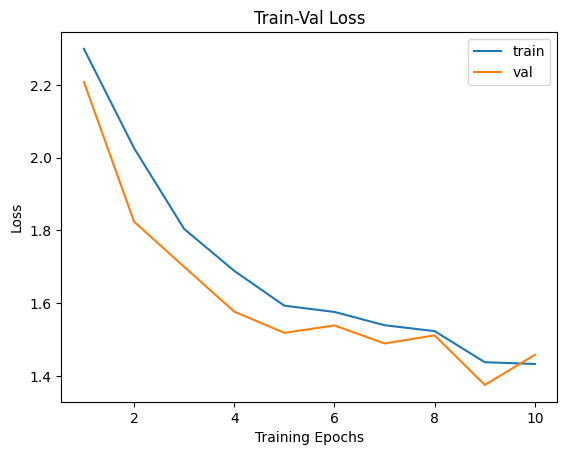

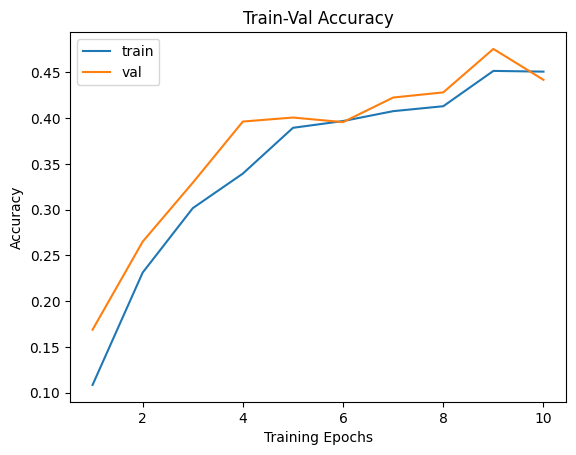

In [24]:
# Train-Validation Progress
num_epochs=epoch

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_history["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_history["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_history["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_history["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

#### 다른 훈련 코드

In [ ]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_size = 0
    running_loss = 0
    corr = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작합니다.
    for batch_idx, (img, lbl) in enumerate(prograss_bar, start=1):
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)
        
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)
        running_size += img.size(0)
        prograss_bar.set_description(f'[Training] loss: {running_loss / running_size:.4f}, accuracy: {corr / running_size:.4f}')
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [ ]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [ ]:
min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(NUM_EPOCHS):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{MODEL_NAME}.pth')
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')